# Factor trading - Policy gradient

Optimise the return of the portfolio by learning the policy from the factor database

NEED TO IMPLEMENT THE REWARD FUNCTION

## 1. load the libraries and constants

In [13]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_FOLDER = 'Data-processed'
FACTOR_FOLDER = 'Data-factor'
TARGET_FOLDER = "Output"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000

## 2. load the data

In [4]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

## 3. Factor trading

In [8]:
df_data["-".join(['US22160K1051',"P"])].values.tolist()

[36.32,
 36.15,
 36.56,
 37.08,
 37.26,
 37.96,
 37.7,
 37.86,
 37.04,
 37.07,
 37.07,
 nan,
 36.4,
 36.55,
 36.5,
 37.35,
 37.12,
 36.69,
 36.08,
 36.9,
 36.94,
 37.22,
 37.13,
 37.3,
 37.92,
 38.14,
 38.31,
 39.41,
 39.15,
 37.75,
 37.61,
 nan,
 nan,
 37.76,
 37.83,
 37.48,
 38.18,
 38.15,
 38.45,
 38.69,
 38.6,
 38.86,
 39.94,
 39.71,
 38.31,
 38.64,
 38.15,
 37.79,
 37.56,
 37.47,
 37.63,
 38.3,
 37.42,
 37.04,
 37.31,
 37.38,
 37.23,
 36.71,
 36.47,
 36.44,
 36.96,
 36.62,
 37.18,
 37.28,
 37.61,
 37.35,
 37.7,
 38.08,
 38.07,
 38.15,
 37.9,
 nan,
 37.66,
 37.16,
 37.7,
 37.37,
 38.08,
 38.04,
 37.79,
 38.31,
 38.29,
 38.54,
 38.09,
 38.04,
 37.99,
 37.66,
 37.5,
 37.58,
 37.47,
 37.41,
 36.3,
 35.66,
 36.42,
 36.12,
 36.55,
 36.07,
 35.85,
 nan,
 35.54,
 36.39,
 36.52,
 36.69,
 36.54,
 36.81,
 37.34,
 37.44,
 38.07,
 37.9,
 nan,
 38.14,
 38.78,
 39.25,
 39.05,
 39.34,
 40.05,
 40.68,
 41.62,
 nan,
 40.96,
 41.47,
 41.56,
 41.6,
 42.02,
 41.82,
 42.14,
 42.89,
 42.51,
 41.82,
 41.

In [6]:
#df = df_full.copy()
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        """
        """
        self.state_size = state_size  #
        self.window_size = window_size  #
        self.half_window = window_size // 2  #
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        """
        """
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        """
        """
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        """
        """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        """
        """
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        """
        """
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [10]:
#close = df.Close.values.tolist()
close = df_data["-".join(['US22160K1051',"P"])].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
epoch: 10, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 20, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 40, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 110, total rewards: 0.000000.3, cost: nan, total money: 10000.0

In [11]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

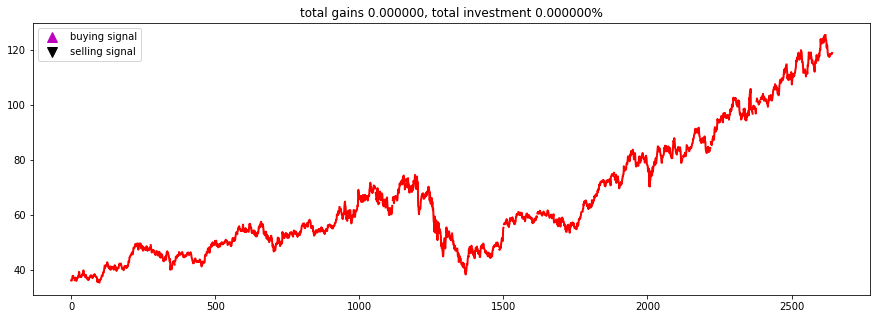

In [14]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()